<h1>Detection hepatitis C status using indirect blood biomarkers</h1>
<h3>Viktoriia Ilina</h3>
<h3>October 2021</h3>

<h2>Overview</h2>
Hepatitis C virus (HCV) is common throughout the world. Globally, an estimated 58 million people have chronic hepatitis C virus infection, with about 1.5 million new infections occurring per year[5]. Most people who become infected with HCV remain persistently infected and became chronic carriers of HCV. This can cause long-term inflammation of the liver and may lead to liver damage and cirrhosis of the liver after many years of infection. People with cirrhosis have an increased risk of liver cancer[6]. Antiviral medicines can cure more than 95% of persons with hepatitis C infection, but access to diagnosis and treatment is low. 

In this project we are trying to detect hepatitis C status using indirect blood biomarkers. The data was extracted from the UCI Machine Learning Repository and scopes laboratory values of six hundred fifteen blood donors and Hepatitis C patients and demographic values like sex and age[7]. 

<h2>Exploratory data analysis</h2>

In [23]:
#Install and import all necessary libraries
!pip install pandas
import pandas as pd
from collections import Counter
!pip install matplotlib
import matplotlib.pyplot as plt
!pip install seaborn==0.11.0
import seaborn as sns
!pip install sklearn==0.24.2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
!pip install imblearn
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Load data
filepath = 'https://github.com/Viktoriia-Ilina/Detection-hepatitis-C-status-using-indirect-blood-biomarkers/blob/main/hcvdata.csv?raw=true'
data = pd.read_csv(filepath)

ERROR: Could not find a version that satisfies the requirement sklearn==0.24.2 (from versions: 0.0)
ERROR: No matching distribution found for sklearn==0.24.2


To begin with, let’s take a quick look at the data. As we can see, our dataset contains 14 attributes:

1. Unnamed: 0 – patient ID;
2. Category (our target variable) – “0=Blood Donor”, “0s=suspect Blood Donor”, “1=Hepatitis”, “2=Fibrosis” or “3=Cirrhosis”; 
3. Age – numeric value in years; 
4. Sex – f = female or m = male;
5. ALB – albumin;
6. ALP – alkaline phosphatase;
7. ALT – alanine amino-transferase;
8. AST – aspartate amino-transferase;
9. BIL – bilirubin; 
10. CHE – choline esterase;
11. CHOL – cholesterol;
12. CREA – creatinine;
13. GGT – gamma-glutamyl-transferase;
14. PROT – protein.

'Category' and 'Sex' columns hold categorical data and all other variables have numerical values here.

In [24]:
data.head()

,Unnamed: 0,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,1,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,2,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,3,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,4,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,5,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7


Now, we drop irrelevant column with patient ID information and all rows containing missing values. As a result, we lost data of twenty six patients, representing 4.23 per cent of initial sample, which is quite acceptable as the loss is not too big.

In [25]:
data = data.drop(['Unnamed: 0'], axis = 'columns')
data = data.dropna()
data

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0=Blood Donor,32,m,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0=Blood Donor,32,m,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0=Blood Donor,32,m,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0=Blood Donor,32,m,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0=Blood Donor,32,m,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,3=Cirrhosis,58,f,34.0,46.4,15.0,150.0,8.0,6.26,3.98,56.0,49.7,80.6
609,3=Cirrhosis,59,f,39.0,51.3,19.6,285.8,40.0,5.77,4.51,136.1,101.1,70.5
610,3=Cirrhosis,62,f,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
611,3=Cirrhosis,64,f,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3


This dataset is strongly imbalanced: we have approximately 90% healthy blood donors and only a rough 10% of people with the disease. It may lead to a high bias in the prediction model: most of the predictions will correspond to the majority class and treat the minority class features as noise in the data and ignore them. So, before fitting the model we should resample data. 

In [26]:
data['Category'].value_counts(normalize = True)

0=Blood Donor             0.893039
3=Cirrhosis               0.040747
1=Hepatitis               0.033956
2=Fibrosis                0.020374
0s=suspect Blood Donor    0.011885
Name: Category, dtype: float64

All patients below the age 30 are positive. The model used will likely put too much weight on this coincidence due to such strong correlation. 

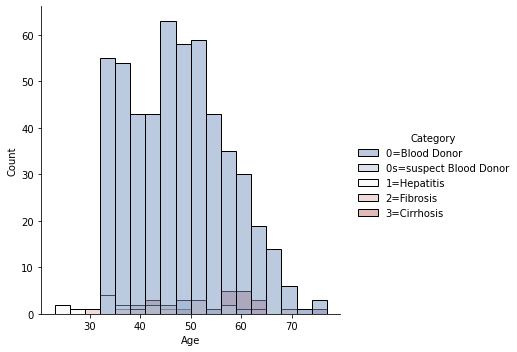

In [27]:
sns.displot(data, x = 'Age', binwidth = 3, hue = 'Category', palette = 'vlag')

There are 363 males and 226 females, disease is more widerspread among males (14.51% among males against 8.13% among female).

In [28]:
data_sex = data.groupby(['Sex', 'Category'])
num_male = data['Sex'].value_counts().loc['m']
num_female = data['Sex'].value_counts().loc['f']
print('Number of males: {}'.format(num_male))
print('Number of females: {}'.format(num_female))
print('Percentage of diseased females: {:.2%}'.format((num_female - len(data_sex.get_group(('f', '0=Blood Donor'))))/len(data_sex.get_group(('f', '0=Blood Donor')))))
print('Percentage of diseased males: {:.2%}'.format((num_male - len(data_sex.get_group(('m', '0=Blood Donor'))))/len(data_sex.get_group(('m', '0=Blood Donor')))))

Number of males: 363
Number of females: 226
Percentage of diseased females: 8.13%
Percentage of diseased males: 14.51%


To evaluate the distribution of blood biomarkers, we check the statistics of the dataset. There seems to be some noise/certain outliers, however, removing them would be inappropriate here. Many different types of conditions can affect the blood result, so we can't differentiate offhand whether the outlier is a marker of hepatitis c, individual characteristic or sigh of an another illness.

In [29]:
data.describe()

,Age,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
count,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000,589.000000
mean,47.417657,41.624278,68.123090,26.575382,33.772835,11.018166,8.203633,5.391341,81.669100,38.198472,71.890153
std,9.931334,5.761794,25.921072,20.863120,32.866871,17.406572,2.191073,1.128954,50.696991,54.302407,5.348883
min,23.000000,14.900000,11.300000,0.900000,10.600000,0.800000,1.420000,1.430000,8.000000,4.500000,44.800000
25%,39.000000,38.800000,52.500000,16.400000,21.500000,5.200000,6.930000,4.620000,68.000000,15.600000,69.300000
50%,47.000000,41.900000,66.200000,22.700000,25.700000,7.100000,8.260000,5.310000,77.000000,22.800000,72.100000
75%,54.000000,45.100000,79.900000,31.900000,31.700000,11.000000,9.570000,6.080000,89.000000,37.600000,75.200000
max,77.000000,82.200000,416.600000,325.300000,324.000000,209.000000,16.410000,9.670000,1079.100000,650.900000,86.500000


Now, it's time to encode our categorical data('Sex' and 'Category' features).

In [30]:
data['Category'] = data['Category'].map({'0=Blood Donor': 0, '0s=suspect Blood Donor': 1, 
                                         '1=Hepatitis' : 2, '2=Fibrosis' : 3, '3=Cirrhosis' : 4})

data['Sex'] = data['Sex'].map({'m': 0, 'f': 1})

data

,Category,Age,Sex,ALB,ALP,ALT,AST,BIL,CHE,CHOL,CREA,GGT,PROT
0,0,32,0,38.5,52.5,7.7,22.1,7.5,6.93,3.23,106.0,12.1,69.0
1,0,32,0,38.5,70.3,18.0,24.7,3.9,11.17,4.80,74.0,15.6,76.5
2,0,32,0,46.9,74.7,36.2,52.6,6.1,8.84,5.20,86.0,33.2,79.3
3,0,32,0,43.2,52.0,30.6,22.6,18.9,7.33,4.74,80.0,33.8,75.7
4,0,32,0,39.2,74.1,32.6,24.8,9.6,9.15,4.32,76.0,29.9,68.7
...,...,...,...,...,...,...,...,...,...,...,...,...,...
608,4,58,1,34.0,46.4,15.0,150.0,8.0,6.26,3.98,56.0,49.7,80.6
609,4,59,1,39.0,51.3,19.6,285.8,40.0,5.77,4.51,136.1,101.1,70.5
610,4,62,1,32.0,416.6,5.9,110.3,50.0,5.57,6.30,55.7,650.9,68.5
611,4,64,1,24.0,102.8,2.9,44.4,20.0,1.54,3.02,63.0,35.9,71.3


The most correlated variables to our target are:
 
- AST (0.7); 
- BIL (0.5);
- GGT (0.5).

Aspartate amino-transferase and gamma-glutamyl-transferase are enzymes helping facilitate fundamental biological processes in the liver[1,4]. Bilirubin is a yellowish substance made during the body's normal process of breaking down red blood cells[2].

The least correlated attributes are:

- ALP (0.04);
- Sex (-0.06);
- PROT (-0.06).

We should keep in mind that correlation does not imply causation.

<AxesSubplot:>

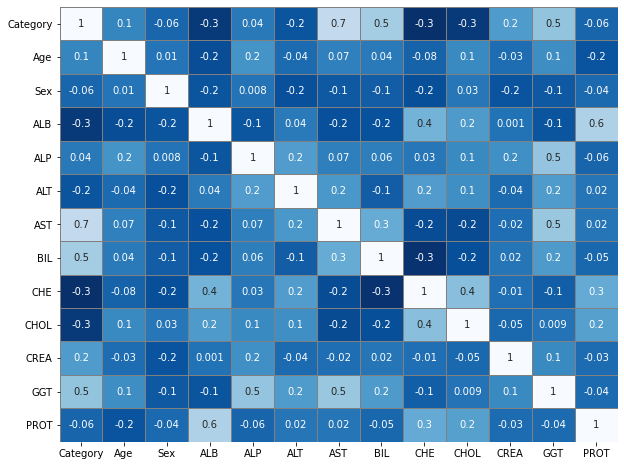

In [31]:
fig, ax = plt.subplots(figsize = (10,8))
sns.heatmap(data.corr(), annot = True, fmt = '.1g', cmap = 'Blues_r', cbar = False, linewidths = 0.5, linecolor = 'grey')

<h2>Methodogy and analysis</h2>

Before proceeding to the models and algorithms, we should split our dataset into training (80%) and testing (20%) sets.

In [32]:
X = data.drop('Category',axis=1)
Y = data['Category']
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=101)

Mindful of the class imbalance, we resample the training set using popular oversampling technique - SMOTE. Why training set only?  In case if we resample whole dataset, the final error estimation (using the test set) will be downwardly biased, and the model will appear to generalize better than it actually will.

In [33]:
counter = Counter(Y_train)
print('Inintial training data',counter)
smote = SMOTE()
X_train,Y_train = smote.fit_resample(X_train,Y_train)
counter = Counter(Y_train)
print('After resampling',counter)

Inintial training data Counter({0: 414, 4: 23, 2: 17, 3: 11, 1: 6})
After resampling Counter({0: 414, 3: 414, 2: 414, 4: 414, 1: 414})


We scale features using RobustScaler, since the centering and scaling statistics of this method is based on percentiles and are therefore not influenced by a few number of very large marginal outliers[3]. 

In [34]:
scaler = RobustScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

To address multi-class classification problem, the next machine learning algorithms will be applied:

- Logistic regression;
- Support vector machine;
- Decision tree;
- Random Forest.

For evaluation of a classification model we should focus not only on the overall accuracy, but also recall taking into account the specificity of the dataset.

              precision    recall  f1-score   support

           0       1.00      0.98      0.99       112
           1       1.00      1.00      1.00         1
           2       1.00      0.67      0.80         3
           3       0.33      1.00      0.50         1
           4       0.50      1.00      0.67         1

    accuracy                           0.97       118
   macro avg       0.77      0.93      0.79       118
weighted avg       0.99      0.97      0.98       118



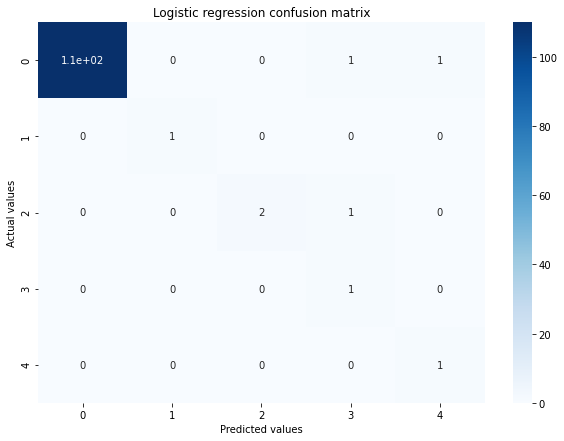

In [68]:
log = LogisticRegression(random_state = 101)
log.fit(X_train, Y_train)
Y_pred = log.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Logistic regression confusion matrix')

print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.97      0.99       112
           1       1.00      1.00      1.00         1
           2       0.67      0.67      0.67         3
           3       0.33      1.00      0.50         1
           4       0.50      1.00      0.67         1

    accuracy                           0.97       118
   macro avg       0.70      0.93      0.76       118
weighted avg       0.98      0.97      0.97       118



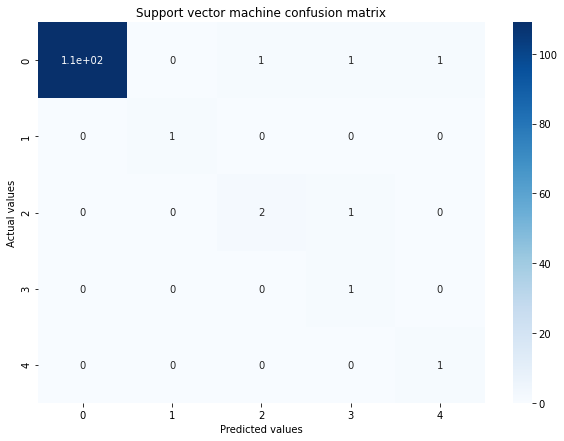

In [69]:
sv = SVC(random_state = 101)
sv.fit(X_train, Y_train)
Y_pred = sv.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Support vector machine confusion matrix')

print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96       112
           1       0.33      1.00      0.50         1
           2       0.50      0.67      0.57         3
           3       0.50      1.00      0.67         1
           4       0.33      1.00      0.50         1

    accuracy                           0.93       118
   macro avg       0.53      0.92      0.64       118
weighted avg       0.96      0.93      0.94       118



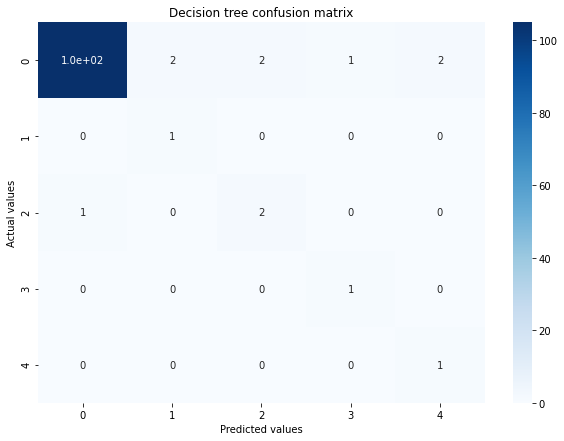

In [70]:
tree = DecisionTreeClassifier(random_state=101)
tree.fit(X_train, Y_train)
Y_pred = tree.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Decision tree confusion matrix')

print(classification_report(Y_test,Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.99      1.00       112
           1       1.00      1.00      1.00         1
           2       0.75      1.00      0.86         3
           3       1.00      1.00      1.00         1
           4       1.00      1.00      1.00         1

    accuracy                           0.99       118
   macro avg       0.95      1.00      0.97       118
weighted avg       0.99      0.99      0.99       118



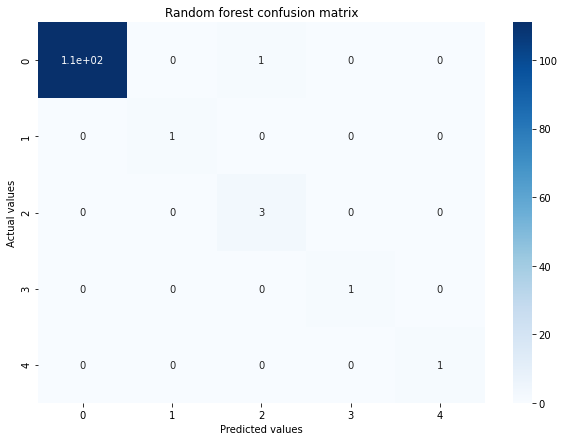

In [71]:
rf = RandomForestClassifier(n_estimators=60, random_state=101)
rf.fit(X_train, Y_train)
Y_pred = rf.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred)
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot = True, cmap = 'Blues')
plt.xlabel('Predicted values')
plt.ylabel('Actual values')
plt.title('Random forest confusion matrix')

print(classification_report(Y_test,Y_pred))

<h2>Summary</h2>

All methods adopted for this study have shown high level of accuracy 93-99%. Random forest model identified correctly the highest number of patients, whereas decision tree model made the most mistakes. Interestingly, support vector classifier and logistic regression made the same mistakes. How regrettable that may be, obtained level of accuracy can be explained by prevalence of healthy individuals in the sample, rather then perfect performance of the model. Besides, there is an important nuance:  we don't have enough data points describing the liver function of young people. This makes our models a weak analytical tool for analyzing the possibility of hepatitis C among people under 35. That is why we strongly recommend not to apply other algorithms (KNN, XGBoost and on and on) and tune hyperparameters trying to improve recall based on initial dataset, and in its turn gather more additional observations  with a focus on infected people.

<h2>References</h2>

1. Aspartate Aminotransferase (AST) - Lab Tests Online. [online] Available at: <https://labtestsonline.org/tests/aspartate-aminotransferase-ast> [Accessed 18 October 2021].
2. Bilirubin Blood Test: MedlinePlus Medical Test. [online] Medlineplus.gov. Available at: <https://medlineplus.gov/lab-tests/bilirubin-blood-test/> [Accessed 18 October 2021].
3. Compare the effect of different scalers on data with outliers. [online] Available at: <https://scikit-learn.org/stable/auto_examples/preprocessing/plot_all_scaling.html> [Accessed 18 October 2021].
4. Gamma-glutamyl Transferase (GGT) Test: MedlinePlus Medical Test. [online] Medlineplus.gov. Available at: <https://medlineplus.gov/lab-tests/gamma-glutamyl-transferase-ggt-test/> [Accessed 18 October 2021].
5. Hepatitis C. [online] Available at: <https://www.who.int/news-room/fact-sheets/detail/hepatitis-c> [Accessed 18 October 2021].
6. Hepatitis C virus infection: information for blood donors. [online] Ncbi.nlm.nih.gov. Available at: <https://www.ncbi.nlm.nih.gov/books/NBK310570/> [Accessed 18 October 2021].
7. UCI Machine Learning Repository: HCV data Data Set. [online] Available at: <https://archive.ics.uci.edu/ml/datasets/HCV+data#> [Accessed 18 October 2021].